In [2]:
# Install system dependencies for rendering in Colab
!apt-get update && apt-get install -y swig libosmesa6-dev patchelf > /dev/null 2>&1

# Install Python packages
!pip install gymnasium[box2d,mujoco] torch matplotlib numpy scipy > /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,077 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Pack

In [3]:
%pip uninstall -y box2d-py swig box2d
%pip install -U pip setuptools wheel
%pip install "box2d==2.3.10"
%pip install "gymnasium>=1.0" pygame



Found existing installation: box2d-py 2.3.5
Uninstalling box2d-py-2.3.5:
  Successfully uninstalled box2d-py-2.3.5
Found existing installation: swig 4.3.1.post0
Uninstalling swig-4.3.1.post0:
  Successfully uninstalled swig-4.3.1.post0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 46.9 MB/s  0:00:00


In [9]:
import os, random, time
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.distributions import Categorical, Normal
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt


# ----- utilities -----
def set_deterministic(seed: int):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.set_num_threads(1)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

def mlp(sizes, activation, output_activation=nn.Identity):
    layers=[]
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(int(sizes[j]), int(sizes[j+1])), act()]
    return nn.Sequential(*layers)

def discount_cumsum(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

def get_flat_params_from(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_flat_params_to(model, flat_params):
    i=0
    for p in model.parameters():
        n = int(np.prod(list(p.size())))
        p.data.copy_(flat_params[i:i+n].view(p.size()))
        i += n

def conjugate_gradient(fvp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros_like(b); r = b.clone(); p = b.clone()
    rdotr = torch.dot(r, r)
    for _ in range(nsteps):
        Avp = fvp(p)
        alpha = rdotr / (torch.dot(p, Avp) + 1e-8)
        x = x + alpha * p
        r = r - alpha * Avp
        new_rdotr = torch.dot(r, r)
        if torch.sqrt(new_rdotr) < residual_tol: break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr
    return x

def explained_variance(y_pred, y_true):
    var_y = torch.var(y_true)
    return 1.0 - torch.var(y_true - y_pred) / (var_y + 1e-8)

# ----- running obs normalization -----
class ObsNorm:
    def __init__(self, shape, eps=1e-8):
        self.n = 0
        self.mean = np.zeros(shape, dtype=np.float64)
        self.M2 = np.zeros(shape, dtype=np.float64)
        self.eps = eps
    def update(self, x):
        x = np.asarray(x, np.float64)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
    @property
    def var(self):
        if self.n < 2: return np.ones_like(self.mean, dtype=np.float64)
        return np.maximum(self.M2 / (self.n - 1), 1e-6)
    def __call__(self, x):
        return ((np.asarray(x, np.float64) - self.mean) / np.sqrt(self.var + self.eps)).astype(np.float32)

In [ ]:
# ----- actor-critic -----
class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space, hidden_sizes=(128,128), activation=nn.Tanh):
        super().__init__()
        obs_dim = int(observation_space.shape[0])

        if isinstance(action_space, gym.spaces.Box):
            self.cont = True
            act_dim = int(action_space.shape[0])
            self.policy_net = mlp([obs_dim]+list(hidden_sizes)+[act_dim], activation)
            log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
            self.log_std = nn.Parameter(torch.as_tensor(log_std))
        else:
            self.cont = False
            act_dim = int(action_space.n)
            self.policy_net = mlp([obs_dim]+list(hidden_sizes)+[act_dim], activation)

        self.value_net = mlp([obs_dim]+list(hidden_sizes)+[1], activation)

    def dist(self, obs):
        if self.cont:
            mu = self.policy_net(obs)
            std = torch.exp(self.log_std).clamp(1e-3, 1e1)
            return Normal(mu, std)
        else:
            logits = self.policy_net(obs)
            return Categorical(logits=logits)

    def step(self, obs_np):
        obs_t = torch.as_tensor(obs_np, dtype=torch.float32)
        with torch.no_grad():
            pi = self.dist(obs_t)
            a = pi.sample()
            logp = self.log_prob(pi, a)
            v = self.value_net(obs_t).squeeze(-1)
        a_env = a.numpy() if self.cont else int(a.item())
        return a_env, float(v.item()), float(logp.item())

    def log_prob(self, pi, a):
        return pi.log_prob(a).sum(-1) if self.cont else pi.log_prob(a)

# ----- buffer -----
class RolloutBuffer:
    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs  = np.zeros((size, obs_dim), np.float32)
        self.act  = np.zeros((size, act_dim), np.float32) if act_dim>0 else np.zeros(size, np.int32)
        self.rew  = np.zeros(size, np.float32)
        self.val  = np.zeros(size, np.float32)
        self.logp = np.zeros(size, np.float32)
        self.adv  = np.zeros(size, np.float32)
        self.ret  = np.zeros(size, np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr = 0
        self.path_start = 0
        self.max_size = size

    def store(self, o, a, r, v, logp):
        self.obs[self.ptr]  = o
        self.act[self.ptr]  = a
        self.rew[self.ptr]  = r
        self.val[self.ptr]  = v
        self.logp[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0.0):
        s = slice(self.path_start, self.ptr)
        rews = np.append(self.rew[s], last_val)
        vals = np.append(self.val[s], last_val)
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv[s] = discount_cumsum(deltas, self.gamma * self.lam)
        self.ret[s] = discount_cumsum(rews, self.gamma)[:-1]
        self.path_start = self.ptr

    def get(self, discrete_actions):
        n = self.ptr
        assert n > 0
        self.ptr = 0; self.path_start = 0
        adv = self.adv[:n]
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)
        data = dict(
            obs=torch.as_tensor(self.obs[:n], dtype=torch.float32),
            ret=torch.as_tensor(self.ret[:n], dtype=torch.float32),
            adv=torch.as_tensor(adv, dtype=torch.float32),
            logp=torch.as_tensor(self.logp[:n], dtype=torch.float32),
        )
        if discrete_actions:
            data["act"] = torch.as_tensor(self.act[:n], dtype=torch.long)
        else:
            data["act"] = torch.as_tensor(self.act[:n], dtype=torch.float32)
        return data

# ----- evaluation -----
def evaluate_policy(env_name, ac, obs_norm, episodes=100, seed=0, deterministic=True, max_ep_len=1000):
    env = gym.make(env_name)
    env.reset(seed=seed+9999)
    returns=[]
    for _ in range(episodes):
        o, _ = env.reset()
        o = obs_norm(o)
        ep_ret = 0.0
        for _ in range(max_ep_len):
            obs_t = torch.as_tensor(o, dtype=torch.float32)
            with torch.no_grad():
                pi = ac.dist(obs_t)
                if deterministic:
                    if ac.cont:
                        a = pi.mean
                    else:
                        a = torch.argmax(pi.probs)
                else:
                    a = pi.sample()
            a_env = a.numpy() if ac.cont else int(a.item())
            if isinstance(env.action_space, gym.spaces.Box):
                a_env = np.clip(a_env, env.action_space.low, env.action_space.high)
            o2, r, term, trunc, _ = env.step(a_env)
            o = obs_norm(o2)
            ep_ret += r
            if term or trunc: break
        returns.append(ep_ret)
    return float(np.mean(returns)), float(np.std(returns))

In [1]:
# === Full TRPO Implementation (fixed eval logging + action clipping) ===
# ----- TRPO -----
def trpo(env_name,
         hidden_sizes=(128,128), activation=nn.Tanh,
         seed=0, steps_per_epoch=30000, epochs=100,
         gamma=0.99, lam=0.95, max_ep_len=1000,
         delta=0.01, cg_iters=15, damping_coeff=0.1,
         backtrack_iters=15, backtrack_coeff=0.8,
         vf_lr=3e-4, train_v_iters=15, vf_clip_delta=10.0,
         ent_coef=1e-2, ent_anneal_ep=60,
         eval_every=10, eval_eps=20, eval_det=True):

    set_deterministic(seed)
    env = gym.make(env_name)
    env.reset(seed=seed)
    obs_dim = int(env.observation_space.shape[0])
    discrete = not isinstance(env.action_space, gym.spaces.Box)
    act_dim = 0 if discrete else int(env.action_space.shape[0])

    ac = MLPActorCritic(env.observation_space, env.action_space, hidden_sizes, activation)
    buf = RolloutBuffer(obs_dim, act_dim, size=steps_per_epoch+max_ep_len, gamma=gamma, lam=lam)
    vf_opt = Adam(ac.value_net.parameters(), lr=vf_lr)

    obs_norm = ObsNorm(obs_dim)

    ent_coef_now = ent_coef
    def anneal_entropy(ep):
        nonlocal ent_coef_now
        ent_coef_now = ent_coef * max(0.0, 1.0 - ep/ent_anneal_ep) if ent_anneal_ep>0 else ent_coef

    def compute_loss_pi(data):
        obs, act, adv, logp_old = data["obs"], data["act"], data["adv"], data["logp"]
        pi = ac.dist(obs)
        logp = ac.log_prob(pi, act)
        ratio = torch.exp(logp - logp_old)
        ent = pi.entropy()
        if ac.cont: ent = ent.sum(-1)
        loss = -(ratio * adv).mean() - ent_coef_now * ent.mean()
        return loss, ent.mean()

    def compute_loss_v(data):
        v = ac.value_net(data["obs"]).squeeze(-1)
        delta_v = torch.clamp(data["ret"] - v, -vf_clip_delta, vf_clip_delta)
        return (delta_v**2).mean()

    def update():
        data = buf.get(discrete_actions=discrete)
        obs_batch = data["obs"]

        loss_pi_old, ent_old = compute_loss_pi(data)
        g = torch.autograd.grad(loss_pi_old, ac.policy_net.parameters(), retain_graph=True)
        g_flat = torch.cat([gi.view(-1) for gi in g])

        with torch.no_grad():
            if ac.cont:
                mu_old = ac.policy_net(obs_batch)
                std_old = torch.exp(ac.log_std).clamp(1e-3, 1e1)
                pi_old = Normal(mu_old, std_old)
            else:
                logits_old = ac.policy_net(obs_batch)
                pi_old = Categorical(logits=logits_old)

        def fvp(v):
            pi_new = ac.dist(obs_batch)
            if ac.cont:
                kl = torch.distributions.kl.kl_divergence(pi_old, pi_new).mean()
            else:
                p_old, p_new = pi_old.probs, pi_new.probs
                kl = (p_old * (torch.log(p_old + 1e-8) - torch.log(p_new + 1e-8))).sum(-1).mean()
            grads = torch.autograd.grad(kl, ac.policy_net.parameters(), create_graph=True)
            flat_grad_kl = torch.cat([g.view(-1) for g in grads])
            kl_v = (flat_grad_kl * v).sum()
            grads_v = torch.autograd.grad(kl_v, ac.policy_net.parameters())
            flat_grad_v = torch.cat([gv.contiguous().view(-1) for gv in grads_v])
            return flat_grad_v + v * damping_coeff

        x = conjugate_gradient(fvp, g_flat, cg_iters)
        sHs = torch.dot(x, fvp(x))
        alpha = torch.sqrt(2 * delta / (sHs + 1e-8))
        old_params = get_flat_params_from(ac.policy_net)

        accepted, kl_after, improve = False, float("inf"), 0.0
        for j in range(backtrack_iters):
            step = alpha * (backtrack_coeff**j) * x
            new_params = old_params - step
            set_flat_params_to(ac.policy_net, new_params)
            with torch.no_grad():
                pi_new = ac.dist(obs_batch)
                if ac.cont:
                    kl_new = torch.distributions.kl.kl_divergence(pi_old, pi_new).mean()
                else:
                    p_old, p_new = pi_old.probs, pi_new.probs
                    kl_new = (p_old * (torch.log(p_old+1e-8)-torch.log(p_new+1e-8))).sum(-1).mean()
                loss_pi_new, _ = compute_loss_pi(data)
            improve = (loss_pi_old - loss_pi_new).item()
            kl_after = kl_new.item()
            if improve > 0 and kl_after <= delta:
                accepted = True
                break
        if not accepted:
            set_flat_params_to(ac.policy_net, old_params)

        # value updates with early stop by EV
        for _ in range(train_v_iters):
            vf_opt.zero_grad()
            lv = compute_loss_v(data)
            if torch.isnan(lv): raise RuntimeError("Value loss NaN")
            lv.backward()
            vf_opt.step()
            with torch.no_grad():
                ev = explained_variance(ac.value_net(data["obs"]).squeeze(-1), data["ret"])
                if ev.item() >= 0.8: break

        return dict(accepted=accepted, kl=kl_after, improve=improve, ent=float(ent_old))

    # ----- training loop (finish episodes, no cutoffs) -----
    start = time.time()
    o, _ = env.reset()
    obs_norm.update(o); o = obs_norm(o)
    ep_ret, ep_len = 0.0, 0
    train_hist = []
    eval_hist, eval_steps = [], []

    for epoch in range(epochs):
        anneal_entropy(epoch)
        epoch_rets = []
        steps = 0
        while steps < steps_per_epoch:
            a, v, logp = ac.step(o)
            if isinstance(env.action_space, gym.spaces.Box):
                a = np.clip(a, env.action_space.low, env.action_space.high)
            o2, r, term, trunc, _ = env.step(a)
            obs_norm.update(o2); o2n = obs_norm(o2)

            ep_ret += r; ep_len += 1
            buf.store(o, a, r, v, logp)
            o = o2n; steps += 1

            timeout = ep_len == max_ep_len
            terminal = term or trunc or timeout
            if terminal:
                last_val = 0.0
                if timeout and not term and not trunc:
                    _, v_boot, _ = ac.step(o)
                    last_val = v_boot
                buf.finish_path(last_val)
                epoch_rets.append(ep_ret)
                o, _ = env.reset()
                obs_norm.update(o); o = obs_norm(o)
                ep_ret, ep_len = 0.0, 0

        # if mid-episode, roll to end to avoid GAE cut
        if ep_len > 0:
            while True:
                a, v, logp = ac.step(o)
                if isinstance(env.action_space, gym.spaces.Box):
                    a = np.clip(a, env.action_space.low, env.action_space.high)
                o2, r, term, trunc, _ = env.step(a)
                obs_norm.update(o2); o2n = obs_norm(o2)
                ep_ret += r; ep_len += 1
                buf.store(o, a, r, v, logp)
                o = o2n
                timeout = ep_len == max_ep_len
                terminal = term or trunc or timeout
                if terminal:
                    last_val = 0.0
                    if timeout and not term and not trunc:
                        _, v_boot, _ = ac.step(o)
                        last_val = v_boot
                    buf.finish_path(last_val)
                    epoch_rets.append(ep_ret)
                    o, _ = env.reset()
                    obs_norm.update(o); o = obs_norm(o)
                    ep_ret, ep_len = 0.0, 0
                    break

        stats = update()
        avg_ret = float(np.mean(epoch_rets)) if len(epoch_rets)>0 else float("nan")
        train_hist.append(avg_ret)

        kl_frac = stats["kl"]/max(delta,1e-8)
        ls_ok = stats["accepted"]
        print(f"Epoch {epoch+1}/{epochs} | AvgRet {avg_ret:.2f} | KL {stats['kl']:.4f}"
              f" ({kl_frac:.2f}·delta) | Improve {stats['improve']:.4f}"
              f" | EntCoef {ent_coef_now:.4f} | Accepted {ls_ok} | T {time.time()-start:.2f}s",
              flush=True)

        if torch.isnan(torch.tensor(stats["kl"])): raise RuntimeError("KL NaN")

        if eval_every and ((epoch+1) % eval_every == 0):
            m, s = evaluate_policy(env_name, ac, obs_norm, episodes=eval_eps,
                                   seed=seed, deterministic=eval_det, max_ep_len=max_ep_len)
            eval_hist.append(float(m))
            eval_steps.append((epoch+1)*steps_per_epoch)
            print(f"[Eval] mean {m:.2f} ± {s:.2f} over {eval_eps} eps", flush=True)

    return {"history": train_hist, "eval_means": eval_hist, "eval_steps": eval_steps,
            "actor_critic": ac, "obs_norm": obs_norm}

def run_trpo_multi(env_name, seeds=(0,1,2,3,4), **kwargs):
    results=[]
    for sd in seeds:
        out = trpo(env_name, seed=sd, **kwargs)
        m,s = evaluate_policy(env_name, out["actor_critic"], out["obs_norm"],
                              episodes=100, seed=sd, deterministic=True,
                              max_ep_len=kwargs.get("max_ep_len",1000))
        print(f"[Seed {sd}] Final eval mean {m:.2f} ± {s:.2f}", flush=True)
        results.append(m)
    print(f"[Multi-seed] mean {np.mean(results):.2f} ± {np.std(results):.2f}")
    return results

# --- Plotting Function ---
def plot_results(env_name, returns, steps_per_epoch):
    plt.figure(figsize=(10, 6))
    steps = np.arange(len(returns)) * steps_per_epoch
    plt.plot(steps, returns)
    plt.title(f'TRPO Performance on {env_name}')
    plt.xlabel('Training Steps')
    plt.ylabel('Average Episodic Return')
    plt.grid(True)
    plt.show()


# CartPole-v1


--- Training on CartPole-v1 ---
Epoch: 1/25 | AvgReturn: 20.11 | Time: 10.14s
Epoch: 2/25 | AvgReturn: 24.86 | Time: 18.72s
Epoch: 3/25 | AvgReturn: 33.80 | Time: 28.08s
Epoch: 4/25 | AvgReturn: 44.15 | Time: 37.42s
Epoch: 5/25 | AvgReturn: 67.03 | Time: 46.57s
Epoch: 6/25 | AvgReturn: 113.60 | Time: 55.37s
Epoch: 7/25 | AvgReturn: 166.14 | Time: 64.42s
Epoch: 8/25 | AvgReturn: 225.88 | Time: 73.47s
Epoch: 9/25 | AvgReturn: 336.62 | Time: 81.85s
Epoch: 10/25 | AvgReturn: 448.86 | Time: 90.77s
Epoch: 11/25 | AvgReturn: 407.17 | Time: 99.79s
Epoch: 12/25 | AvgReturn: 485.30 | Time: 109.31s
Epoch: 13/25 | AvgReturn: 432.41 | Time: 117.97s
Epoch: 14/25 | AvgReturn: 476.10 | Time: 126.84s
Epoch: 15/25 | AvgReturn: 484.10 | Time: 135.63s
Epoch: 16/25 | AvgReturn: 469.24 | Time: 144.06s
Epoch: 17/25 | AvgReturn: 500.00 | Time: 153.72s
Epoch: 18/25 | AvgReturn: 475.95 | Time: 162.65s
Epoch: 19/25 | AvgReturn: 500.00 | Time: 171.20s
Epoch: 20/25 | AvgReturn: 452.67 | Time: 180.08s
Epoch: 21/25

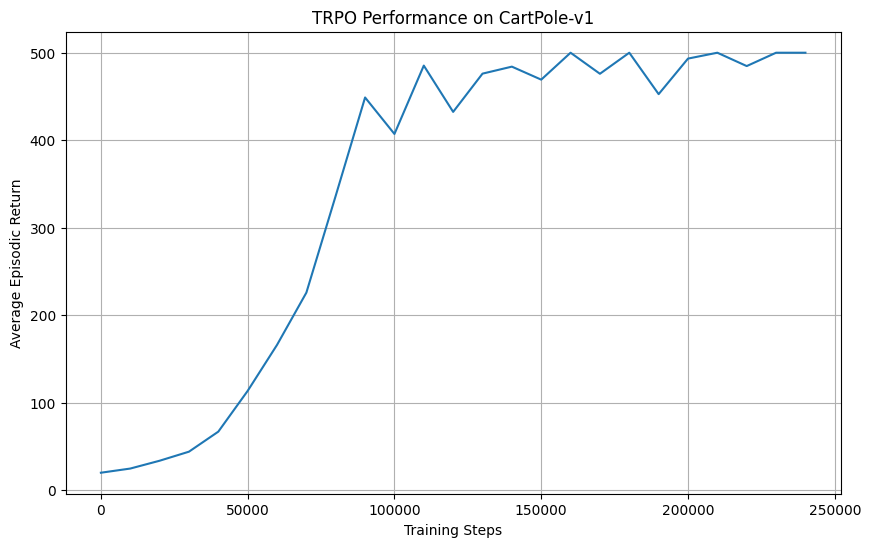

In [ ]:
if __name__ == '__main__':
    env_name = 'CartPole-v1'
    print(f"\n--- Training on {env_name} ---")
    returns = trpo(env_name, epochs=25, steps_per_epoch=10000)
    plot_results(env_name, returns, 10000)

# Acrobot-v1


--- Training on Acrobot-v1 ---
Epoch: 1/50 | AvgReturn: -500.00 | Time: 12.14s
Epoch: 2/50 | AvgReturn: -496.30 | Time: 23.59s
Epoch: 3/50 | AvgReturn: -437.14 | Time: 34.88s
Epoch: 4/50 | AvgReturn: -374.23 | Time: 46.27s
Epoch: 5/50 | AvgReturn: -311.58 | Time: 57.46s
Epoch: 6/50 | AvgReturn: -296.73 | Time: 68.76s
Epoch: 7/50 | AvgReturn: -235.83 | Time: 80.20s
Epoch: 8/50 | AvgReturn: -234.24 | Time: 91.90s
Epoch: 9/50 | AvgReturn: -235.26 | Time: 103.45s
Epoch: 10/50 | AvgReturn: -188.23 | Time: 114.17s
Epoch: 11/50 | AvgReturn: -169.66 | Time: 125.24s
Epoch: 12/50 | AvgReturn: -145.00 | Time: 136.23s
Epoch: 13/50 | AvgReturn: -139.66 | Time: 147.55s
Epoch: 14/50 | AvgReturn: -127.95 | Time: 158.79s
Epoch: 15/50 | AvgReturn: -122.22 | Time: 169.92s
Epoch: 16/50 | AvgReturn: -112.75 | Time: 181.28s
Epoch: 17/50 | AvgReturn: -110.35 | Time: 192.82s
Epoch: 18/50 | AvgReturn: -105.74 | Time: 205.71s
Epoch: 19/50 | AvgReturn: -98.74 | Time: 217.34s
Epoch: 20/50 | AvgReturn: -102.50 | 

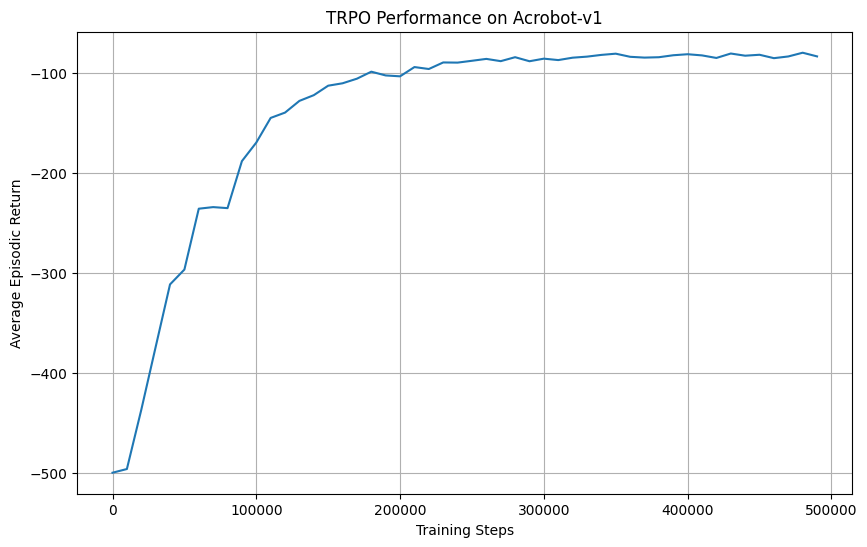

In [ ]:
if __name__ == '__main__':
    env_name = 'Acrobot-v1'
    epoch = 50
    print(f"\n--- Training on {env_name} ---")
    returns = trpo(env_name, epochs=epoch, steps_per_epoch=10000)
    plot_results(env_name, returns, 10000)


# InvertedPendulum-v5


--- Training on InvertedPendulum-v5 ---
Epoch 1/20 | AvgRet 10.07 | KL 0.0045 (0.89·delta) | Improve 0.0242 | EntCoef 0.0030 | Accepted True | T 4.06s
Epoch 2/20 | AvgRet 12.31 | KL 0.0048 (0.96·delta) | Improve 0.0269 | EntCoef 0.0026 | Accepted True | T 7.98s
Epoch 3/20 | AvgRet 16.24 | KL 0.0032 (0.63·delta) | Improve 0.0215 | EntCoef 0.0023 | Accepted True | T 12.60s
Epoch 4/20 | AvgRet 18.71 | KL 0.0032 (0.64·delta) | Improve 0.0224 | EntCoef 0.0019 | Accepted True | T 16.51s
Epoch 5/20 | AvgRet 22.72 | KL 0.0032 (0.64·delta) | Improve 0.0225 | EntCoef 0.0015 | Accepted True | T 20.48s
[Eval] mean 79.55 ± 3.73 over 20 eps
Epoch 6/20 | AvgRet 30.65 | KL 0.0049 (0.98·delta) | Improve 0.0262 | EntCoef 0.0011 | Accepted True | T 25.59s
Epoch 7/20 | AvgRet 40.90 | KL 0.0047 (0.95·delta) | Improve 0.0237 | EntCoef 0.0008 | Accepted True | T 29.48s
Epoch 8/20 | AvgRet 62.85 | KL 0.0047 (0.94·delta) | Improve 0.0193 | EntCoef 0.0004 | Accepted True | T 33.46s
Epoch 9/20 | AvgRet 77.57 | 

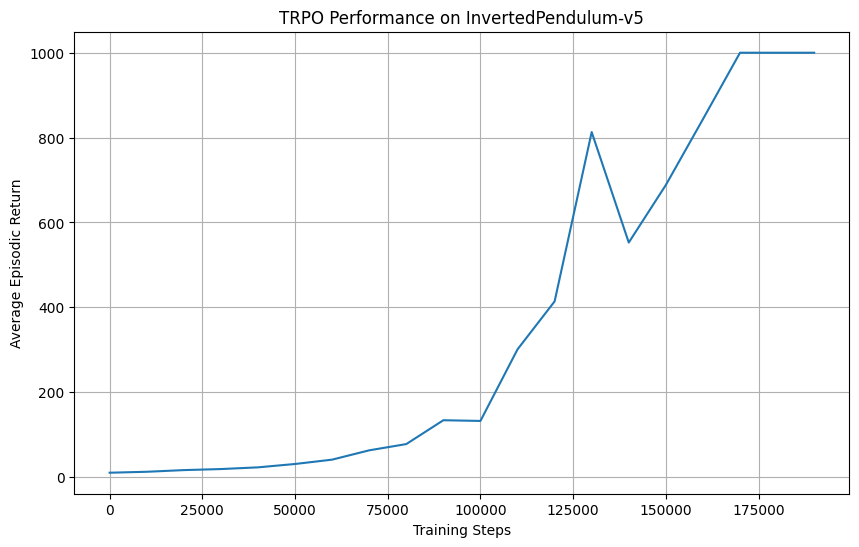

In [ ]:
if __name__ == '__main__':
    env_name = 'InvertedPendulum-v5'
    print(f"\n--- Training on {env_name} ---")
out = trpo(
    env_name,
    hidden_sizes=(64,64),
    epochs=20,
    steps_per_epoch=5_000,
    max_ep_len=1_000,
    gamma=0.99, lam=0.95,
    delta=0.005, cg_iters=20, damping_coeff=0.1,
    backtrack_iters=15, backtrack_coeff=0.8,
    vf_lr=3e-4, train_v_iters=30, vf_clip_delta=10.0,
    ent_coef=0.003, ent_anneal_ep=8,
    eval_every=5, eval_eps=20, eval_det=True, seed=0
)
    # trpo returns a dict; plot the learning curve from its history
returns = out["history"] if isinstance(out, dict) else out
plot_results(env_name, returns, 10_000)


# HalfCheetah-v5

Epoch 1/120 | AvgRet -276.68 | KL 0.0080 (0.80·delta) | Improve 0.0251 | EntCoef 0.0200 | Accepted True | T 135.96s
Epoch 2/120 | AvgRet -188.41 | KL 0.0076 (0.76·delta) | Improve 0.0211 | EntCoef 0.0198 | Accepted True | T 274.32s
Epoch 3/120 | AvgRet -164.66 | KL 0.0070 (0.70·delta) | Improve 0.0184 | EntCoef 0.0196 | Accepted True | T 410.39s
Epoch 4/120 | AvgRet -115.32 | KL 0.0074 (0.74·delta) | Improve 0.0187 | EntCoef 0.0194 | Accepted True | T 548.88s
Epoch 5/120 | AvgRet -89.23 | KL 0.0073 (0.73·delta) | Improve 0.0202 | EntCoef 0.0192 | Accepted True | T 685.77s
Epoch 6/120 | AvgRet -7.53 | KL 0.0073 (0.73·delta) | Improve 0.0203 | EntCoef 0.0190 | Accepted True | T 825.75s
Epoch 7/120 | AvgRet 71.83 | KL 0.0074 (0.74·delta) | Improve 0.0216 | EntCoef 0.0188 | Accepted True | T 962.68s
Epoch 8/120 | AvgRet 158.39 | KL 0.0068 (0.68·delta) | Improve 0.0196 | EntCoef 0.0186 | Accepted True | T 1099.97s
Epoch 9/120 | AvgRet 204.79 | KL 0.0070 (0.70·delta) | Improve 0.0208 | EntCo

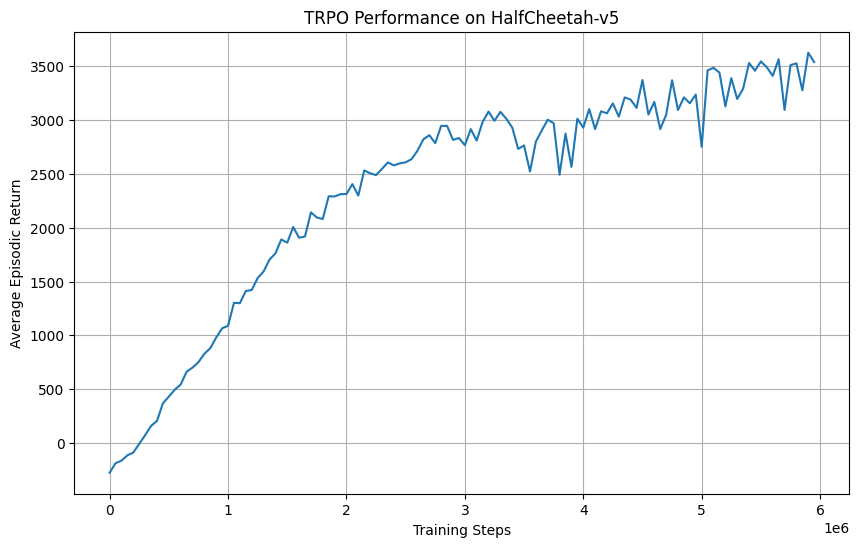

In [ ]:
out = trpo(
    "HalfCheetah-v5",
    hidden_sizes=(256, 256),
    epochs=120,
    steps_per_epoch=50_000,   # ~6M steps total
    max_ep_len=1_000,
    gamma=0.99, lam=0.97,
    delta=0.01, cg_iters=20, damping_coeff=0.1,
    backtrack_iters=15, backtrack_coeff=0.8,
    vf_lr=3e-4, train_v_iters=40, vf_clip_delta=10.0,
    ent_coef=0.02, ent_anneal_ep=100,
    eval_every=10, eval_eps=20, eval_det=True,
    seed=0
)
returns = out["history"] if isinstance(out, dict) else out
plot_results("HalfCheetah-v5", returns, 50_000)


# LunarLander-v3

/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Epoch 1/80 | AvgRet -186.80 | KL 0.0070 (0.70·delta) | Improve 0.0096 | EntCoef 0.0200 | Accepted True | T 45.85s


/tmp/ipython-input-3443291001.py:314: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return dict(accepted=accepted, kl=kl_after, improve=improve, ent=float(ent_old))


Epoch 2/80 | AvgRet -142.69 | KL 0.0078 (0.78·delta) | Improve 0.0109 | EntCoef 0.0198 | Accepted True | T 86.28s
Epoch 3/80 | AvgRet -124.03 | KL 0.0076 (0.76·delta) | Improve 0.0119 | EntCoef 0.0195 | Accepted True | T 125.50s
Epoch 4/80 | AvgRet -101.29 | KL 0.0068 (0.68·delta) | Improve 0.0120 | EntCoef 0.0192 | Accepted True | T 165.22s
Epoch 5/80 | AvgRet -81.78 | KL 0.0072 (0.72·delta) | Improve 0.0110 | EntCoef 0.0190 | Accepted True | T 205.05s
Epoch 6/80 | AvgRet -57.51 | KL 0.0075 (0.75·delta) | Improve 0.0096 | EntCoef 0.0187 | Accepted True | T 244.60s
Epoch 7/80 | AvgRet -49.04 | KL 0.0076 (0.76·delta) | Improve 0.0105 | EntCoef 0.0185 | Accepted True | T 282.90s
Epoch 8/80 | AvgRet -30.69 | KL 0.0072 (0.72·delta) | Improve 0.0098 | EntCoef 0.0182 | Accepted True | T 320.34s
Epoch 9/80 | AvgRet -15.93 | KL 0.0081 (0.81·delta) | Improve 0.0108 | EntCoef 0.0180 | Accepted True | T 359.92s
Epoch 10/80 | AvgRet -13.71 | KL 0.0079 (0.79·delta) | Improve 0.0086 | EntCoef 0.0177

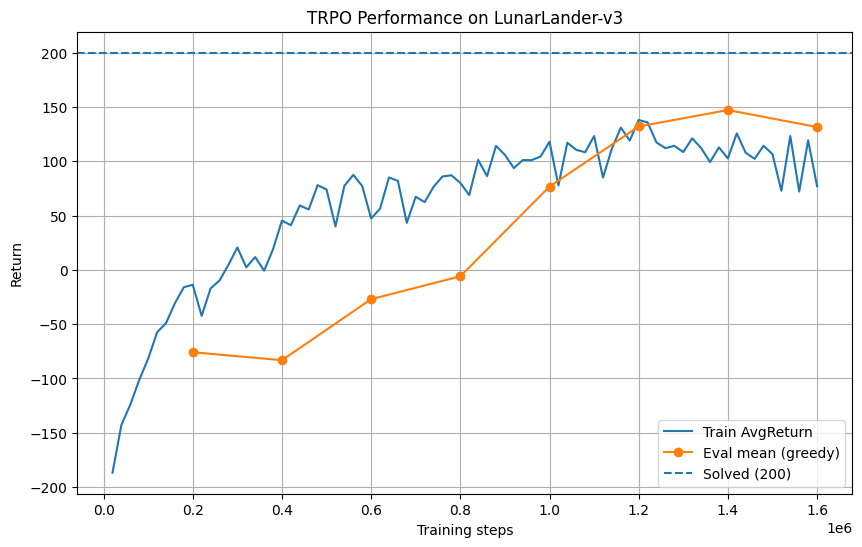

In [ ]:
steps_per_epoch = 20_000
out = trpo("LunarLander-v3", hidden_sizes=(256,256), epochs=80, steps_per_epoch=steps_per_epoch,
           max_ep_len=1_000, gamma=0.99, lam=0.97, delta=0.01, cg_iters=15, damping_coeff=0.1,
           backtrack_iters=15, backtrack_coeff=0.8, vf_lr=3e-4, train_v_iters=30, vf_clip_delta=10.0,
           ent_coef=0.02, ent_anneal_ep=80, eval_every=10, eval_eps=50, eval_det=True, seed=0)

hist = out["history"] if isinstance(out, dict) else out
eval_means = out["eval_means"] if isinstance(out, dict) else []
eval_steps = out["eval_steps"] if isinstance(out, dict) else []

import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title(f'TRPO Performance on LunarLander-v3')
plt.plot(np.arange(1, len(hist)+1)*steps_per_epoch, hist, label="Train AvgReturn")
if eval_means:
    plt.plot(eval_steps, eval_means, marker="o", label="Eval mean (greedy)")
plt.axhline(200, linestyle="--", label="Solved (200)")
plt.xlabel("Training steps"); plt.ylabel("Return"); plt.legend(); plt.grid(True); plt.show()
